In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jeju-dataset/submission.csv
/kaggle/input/jeju-dataset/201901-202003.csv


# ▶ 해결해야 하는 문제
- 2020.04, 2020.07 기간 내 (지역,업종) 별 (월간 총 사용 금액) 예측


- 1. 201901-202003.csv (2.07 GB)
- 2019.01 ~ 2020.03 기간 내 카드 데이터


- 2. 202004.csv (116 MB)
- 2020.04 기간 내 카드 데이터 (7/28 공개)

# 평가지표
- RMSLE (Root Mean Square Logarithmic Error) 
- 제주 지역에 3배 가중치 부여

In [ ]:
# REG_YYMM : 년월
# 카드이용지역_시도 (가맹점 주소 기준) 
# 카드이용지역_시군구 (가맹점 주소 기준)  
# 업종명 
# 거주지역_시도 (고객 집주소 기준) 
# 거주지역_시군구 (고객 집주소 기준) 
# 연령 
# 성별 
# FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
# CSTNR_CNT : 이용고객수 (명)  
# AMT : 이용금액 (원)  
# CNT : 이용건수 (건)  

In [2]:
train = pd.read_csv("/kaggle/input/jeju-dataset/201901-202003.csv")
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [3]:
# 날짜 전처리 2019.01 ~ 2020.03

train["year"] = np.floor(train["REG_YYMM"]/100).astype(int)
train["month"] = np.floor(train["REG_YYMM"]%100).astype(int)

train = train.drop(["REG_YYMM"], axis = 1)
train

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,2020,3
24697788,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,2020,3
24697789,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,2020,3
24697790,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,2020,3


In [4]:
# train.isna().sum()

# 총 데이터
# train         24697792

# 결측치
# CARD_CCG_NM      87213
# HOM_CCG_NM      147787

# 24697792개 데이터 중, (카드사용지역,카드사용자거주지역)의 구체적인 위치(시군구)의 결측치(1%이하)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in train.columns[train.dtypes == object]:
    
    train[i] = le.fit_transform(list(train[i]))

train.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,0,4,0,0,4,1,1,1,4,311200,4,2019,1
1,0,4,0,0,4,2,1,2,7,1374500,8,2019,1
2,0,4,0,0,4,2,2,2,6,818700,6,2019,1
3,0,4,0,0,4,3,1,3,4,1717000,5,2019,1
4,0,4,0,0,4,3,1,4,3,1047300,3,2019,1


In [6]:
# 데이터 재구성, 모든 경우
from itertools import product

matrix = []

for i in range(1):
    matrix.append(np.array(list(product(train["year"].unique(), train["month"].unique(),train["CARD_SIDO_NM"].unique(), train["STD_CLSS_NM"].unique() )), dtype = np.int16)) 

matrix = pd.DataFrame(np.vstack(matrix))
matrix.columns = ["year","month","CARD_SIDO_NM","STD_CLSS_NM"]
matrix

,year,month,CARD_SIDO_NM,STD_CLSS_NM
0,2019,1,0,0
1,2019,1,0,1
2,2019,1,0,2
3,2019,1,0,3
4,2019,1,0,5
...,...,...,...,...
16723,2020,12,16,35
16724,2020,12,16,8
16725,2020,12,16,12
16726,2020,12,16,4


In [7]:
# 매월 지역별 업종의 총 이용금액
month_AMT = train.groupby(['year',"month", 'CARD_SIDO_NM', 'STD_CLSS_NM'])["AMT"].sum().reset_index()
month_AMT

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,2019,1,0,0,148354746
1,2019,1,0,1,1229200312
2,2019,1,0,2,1286979106
3,2019,1,0,3,30656770
4,2019,1,0,5,13101500
...,...,...,...,...,...
9433,2020,3,16,36,1315245299
9434,2020,3,16,37,16152482704
9435,2020,3,16,38,15248550
9436,2020,3,16,39,428881434


In [8]:
matrix = matrix.drop(matrix[(matrix["year"]==2020) & (matrix["month"]>3)].index)
matrix

,year,month,CARD_SIDO_NM,STD_CLSS_NM
0,2019,1,0,0
1,2019,1,0,1
2,2019,1,0,2
3,2019,1,0,3
4,2019,1,0,5
...,...,...,...,...
10450,2020,3,16,35
10451,2020,3,16,8
10452,2020,3,16,12
10453,2020,3,16,4


In [9]:
matrix2 = pd.merge(matrix,month_AMT,on=["year","month","CARD_SIDO_NM","STD_CLSS_NM"], how="left")
matrix2

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,2019,1,0,0,1.483547e+08
1,2019,1,0,1,1.229200e+09
2,2019,1,0,2,1.286979e+09
3,2019,1,0,3,3.065677e+07
4,2019,1,0,5,1.310150e+07
...,...,...,...,...,...
10450,2020,3,16,35,9.933600e+05
10451,2020,3,16,8,9.420000e+05
10452,2020,3,16,12,NaN
10453,2020,3,16,4,NaN


In [10]:
# 모든 경우 중 사용금액이 결측치인 곳
matrix2[(matrix2["year"] == 2020) & (matrix2["month"] == 3) & (matrix2["CARD_SIDO_NM"] == 16)].tail(10)

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
10445,2020,3,16,40,12733490.0
10446,2020,3,16,23,NaN
10447,2020,3,16,28,NaN
10448,2020,3,16,14,NaN
10449,2020,3,16,15,NaN
10450,2020,3,16,35,993360.0
10451,2020,3,16,8,942000.0
10452,2020,3,16,12,NaN
10453,2020,3,16,4,NaN
10454,2020,3,16,30,NaN


In [11]:
# 결측치 처리 - 판매량 0으로 채움

matrix2 = matrix2.fillna(0)
matrix2[(matrix2["year"] == 2020) & (matrix2["month"] == 3) & (matrix2["CARD_SIDO_NM"] == 16)].tail(10)

# -> 업종 4,12,14,15,23,28,30의 7개 업종은 매월 사용량 발생이 적음

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
10445,2020,3,16,40,12733490.0
10446,2020,3,16,23,0.0
10447,2020,3,16,28,0.0
10448,2020,3,16,14,0.0
10449,2020,3,16,15,0.0
10450,2020,3,16,35,993360.0
10451,2020,3,16,8,942000.0
10452,2020,3,16,12,0.0
10453,2020,3,16,4,0.0
10454,2020,3,16,30,0.0


In [12]:
# 평가셋 만들기
# 2019.01 ~ 2020.02 로 2020.03 예측하는 평가셋

# matrix2[(matrix2["year"] == 2020) & (matrix2["month"] == 2) & (matrix2["CARD_SIDO_NM"] == 16)] # 2020.02까지 index는 9757

x_train = matrix2.iloc[:9758,:].drop(["AMT"], axis=1)  # 2019.01 ~ 2020.02까지의 총 사용금액 데이터 (9758)
y_train = pd.DataFrame(matrix2.iloc[:9758,:]["AMT"])

x_valid = matrix2.iloc[9758:,:].drop(["AMT"], axis=1)  # 2020.03 한달의 데이터 (697)
y_valid = pd.DataFrame(matrix2.iloc[9758:,:]["AMT"])

# 시각화

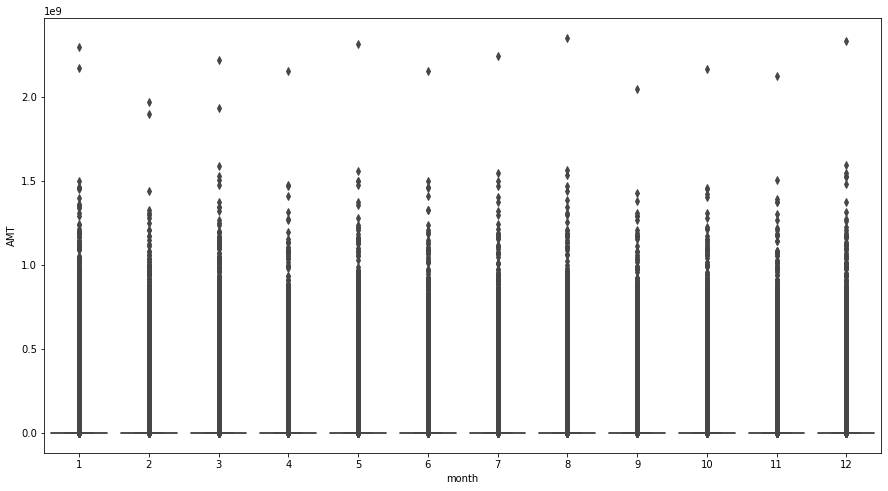

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
sns.boxplot(train["month"],train["AMT"] )

In [14]:
# 제출양식
sub = pd.read_csv("/kaggle/input/jeju-dataset/submission.csv")
sub.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,0
1,1,202004,강원,골프장 운영업,0
2,2,202004,강원,과실 및 채소 소매업,0
3,3,202004,강원,관광 민예품 및 선물용품 소매업,0
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0


In [15]:
# test set 만들기
test = sub.drop(["id"], axis=1)

test["year"] = np.floor(test["REG_YYMM"]/100).astype(int)
test["month"] = np.floor(test["REG_YYMM"]%100).astype(int)

test = test.drop(["REG_YYMM","AMT"], axis = 1)

for i in test.columns[test.dtypes == object]:
    test[i] = le.fit_transform(list(test[i]))
    
test.head()

,CARD_SIDO_NM,STD_CLSS_NM,year,month
0,0,0,2020,4
1,0,1,2020,4
2,0,2,2020,4
3,0,3,2020,4
4,0,4,2020,4


In [36]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(n_estimators = 2000)
cat.fit(x_train,y_train, eval_set = (x_valid, y_valid), early_stopping_rounds = 15)
result = cat.predict(test)

# from lightgbm import LGBMRegressor
# lgb = LGBMRegressor(n_estimators = 2000)
# lgb.fit(x_train,y_train, eval_set = (x_valid, y_valid), early_stopping_rounds = 15)
# result = lgb.predict(test)


[1]	valid_0's l2: 2.08375e+20
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 1.81016e+20
[3]	valid_0's l2: 1.59196e+20
[4]	valid_0's l2: 1.41849e+20
[5]	valid_0's l2: 1.28535e+20
[6]	valid_0's l2: 1.18047e+20
[7]	valid_0's l2: 1.05332e+20
[8]	valid_0's l2: 9.52517e+19
[9]	valid_0's l2: 8.71903e+19
[10]	valid_0's l2: 8.10383e+19
[11]	valid_0's l2: 7.73197e+19
[12]	valid_0's l2: 7.30437e+19
[13]	valid_0's l2: 6.6201e+19
[14]	valid_0's l2: 6.19653e+19
[15]	valid_0's l2: 5.74393e+19
[16]	valid_0's l2: 5.55056e+19
[17]	valid_0's l2: 5.25828e+19
[18]	valid_0's l2: 5.05048e+19
[19]	valid_0's l2: 4.82679e+19
[20]	valid_0's l2: 4.62053e+19
[21]	valid_0's l2: 4.45095e+19
[22]	valid_0's l2: 4.36029e+19
[23]	valid_0's l2: 4.24695e+19
[24]	valid_0's l2: 4.14402e+19
[25]	valid_0's l2: 3.96887e+19
[26]	valid_0's l2: 3.77829e+19
[27]	valid_0's l2: 3.7038e+19
[28]	valid_0's l2: 3.64406e+19
[29]	valid_0's l2: 3.57495e+19
[30]	valid_0's l2: 3.48818e+19
[31]	valid_0's l2: 3

In [37]:
sub["AMT"] = result
sub.head()

# (-)값 발생?

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,5.255994e+07
1,1,202004,강원,골프장 운영업,5.255994e+07
2,2,202004,강원,과실 및 채소 소매업,-1.991476e+08
3,3,202004,강원,관광 민예품 및 선물용품 소매업,-6.303658e+06
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,-6.303658e+06


In [40]:
sub[sub["AMT"] < 0].count()

id              51
REG_YYMM        51
CARD_SIDO_NM    51
STD_CLSS_NM     51
AMT             51
dtype: int64

In [39]:
sub.to_csv("jeju.csv",index = False)